# 시작하기에 앞서

시계열 데이터의 평균과 분산이 일정할 때 **안정적 Stationarity** 을 갖는다고 한다.  

우리가 처음에 받는 데이터는 수식적으로 다루기 **"어려운"** 데이터이다.  

그렇기 때문에 우리가 시계열 분석을 하기에 앞서 다루기 **쉬운** 데이터로 바꿔줄 필요가 있다.  

그 다루기 쉬운 데이터가 바로 **안정적 시계열** 데이터라고 부른다.  

이번 프로젝트에서는 시계열 데이터를 어떻게하면 **안정적 시계열**로 변환할 수 있는 지에 대해서 다루게 된다.  

그리고 우린 바뀐 데이터로 미래를 예측하는 분석을 실행하였다.  

# STEP 1 : 시계열 데이터 준비

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = "../../data/KSH.csv"
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2008-02-14    174000.0
2008-02-15    169500.0
2008-02-18    170000.0
2008-02-19    170500.0
2008-02-20    173500.0
Name: Close, dtype: float64

필요한 모듈을 import 시킨다.  
이번 과제에서는 numpy, pandas, matplotlib을 사용한다.

# STEP 2 : 각종 전처리 수행

In [264]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

ts.interpolate는 시계열 데이터의 값에 따라 선형적으로 보간하는 방식이다.  
결측치(null)가 있는 경우를 대비해서 보간한 후에 다시 확인한다.  

In [265]:
# 로그 변환
ts_log = np.log(ts)

여기서 ts(time series) log함수를 사용해서 변환시켜준다.  
그렇다면 왜 여기서 log함수를 사용했을까?  
우리가 사용하는 데이터는 시간이 흐름에 따라 크기가 커지게 되고 그만큼 변화폭도 커지게 된다.  
하지만 우리가 확인하고 싶은 내용은 그 시점의 주가에 비해 얼마나 변화했느냐이지  
과거보다 현재의 폭이 크다고 해서 더 중요한 것은 아니다.  
쉽게 말하자면 해당 시점 마다의 상대적 증감을 보고 싶은 것이다.  
이런 역할을 잘 수행하는 함수가 바로 log함수이다.  
변화량의 크기가 너무 크거나 데이터가 쓸데없이 길어서 추이를 확인하는데 걸림돌이 된다면  
큰 값에 강한 log를 사용해서 골고루 분포하게 만들어준다.  

# STEP 3 : 시계열 안정성 분석

In [266]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

위는 일정 시간내에서 구간 통계치(Rolling Statistics)를 시각화하는 함수이다.  
쉽게 말하자면 원본 시계열과 이동된 시계열을 비교해서 **경향성**을 더 뚜렷하게 보자는 의미다.  
만약 window가 12라면 시계열을 12만큼 옮겨서 비교하게 된다.  
그럼 과거 12개와 현재 12개가 비교되면서 변화를 눈으로 확인하기 쉬워진다.  

In [267]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 사용하는 통계 패키지이다.  
여기서 사용하는 adfuller은 ADF라는 검정함수를 제공한다.  
ADF 검정은 쉽게 말해서 시계열 데이터가 안정적(stationary)인지 테스트 하는 방법이다.  

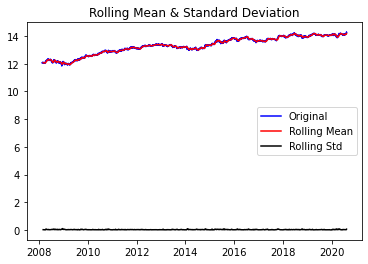

Results of Dickey-Fuller Test:
Test Statistic                   -1.294181
p-value                           0.631830
#Lags Used                       11.000000
Number of Observations Used    3090.000000
Critical Value (1%)              -3.432468
Critical Value (5%)              -2.862476
Critical Value (10%)             -2.567268
dtype: float64


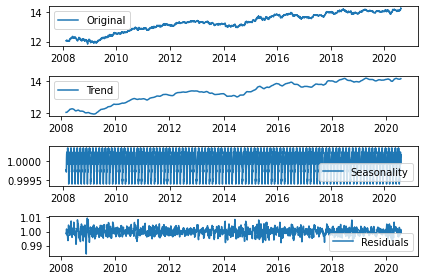

In [268]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [269]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.478061e+01
p-value                        2.248563e-27
#Lags Used                     2.900000e+01
Number of Observations Used    3.042000e+03
Critical Value (1%)           -3.432501e+00
Critical Value (5%)           -2.862491e+00
Critical Value (10%)          -2.567276e+00
dtype: float64


p-value가 1.036035e-28이고 거의 0에 가까움으로 안정적 시계열이라는 대립가설을 채택할 수 있다.  

# STEP 4 : 학습, 테스트 데이터셋 생성

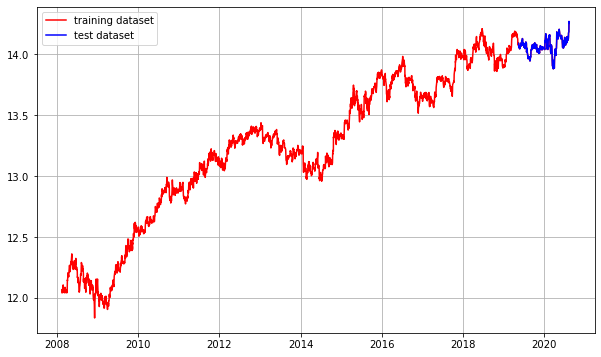

In [270]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

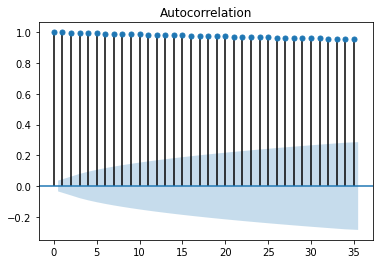

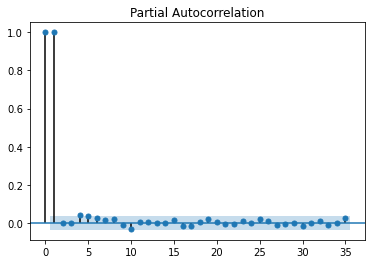

In [271]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 볼 때 p가 2 이상인 구간에서 PACF는 거의 0에 가까워지기 때문에 p=1이 매우 적합해보인다.  
반면에 ACF는 점차 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다  

Results of Dickey-Fuller Test:
Test Statistic                -1.790994e+01
p-value                        2.932074e-30
#Lags Used                     1.000000e+01
Number of Observations Used    3.090000e+03
Critical Value (1%)           -3.432468e+00
Critical Value (5%)           -2.862476e+00
Critical Value (10%)          -2.567268e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.771798e+01
p-value                        3.478537e-30
#Lags Used                     2.900000e+01
Number of Observations Used    3.070000e+03
Critical Value (1%)           -3.432482e+00
Critical Value (5%)           -2.862482e+00
Critical Value (10%)          -2.567271e+00
dtype: float64


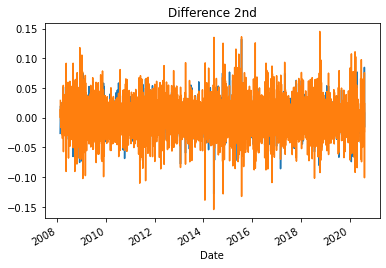

In [272]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

실험을 위해서 2차 차분을 구했지만 1차를 구했을 때 이미 안정화 상태를 보였음으로 1차만 구해도 된다.

# STEP 6 : ARIMA 모델 훈련과 테스트

## ARIMA 모델 빌드와 훈련

In [273]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2791
Model:                     ARMA(1, 0)   Log Likelihood                6675.429
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 13 Aug 2020   AIC                         -13344.857
Time:                        17:00:53   BIC                         -13327.055
Sample:                             0   HQIC                        -13338.430
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.1172      0.686     19.125      0.000      11.773      14.461
ar.L1.Close     0.9997      0.000   2490.001      0.000       0.999       1.000
                                    Roots       

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## 모델 테스트 및 플로팅

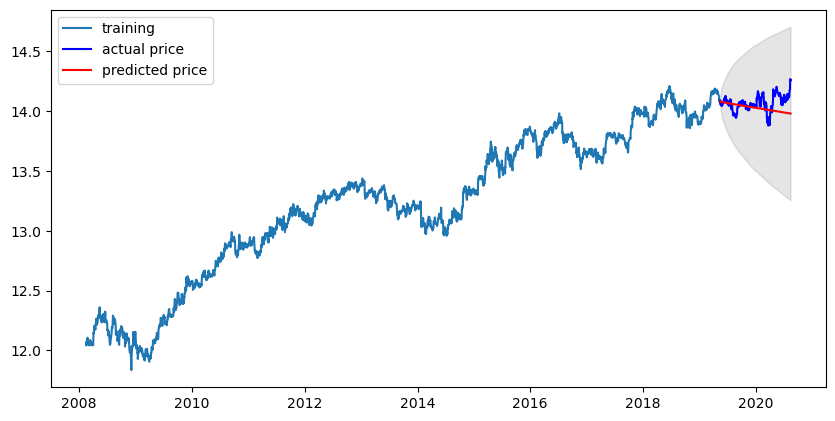

In [274]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

## 최종 예측 모델 정확도 측정(MAPE)

In [275]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12834275277.054686
MAE:  83654.11367862315
RMSE:  113288.46047614331
MAPE: 6.31%


# 마무리

### Intel의 경우

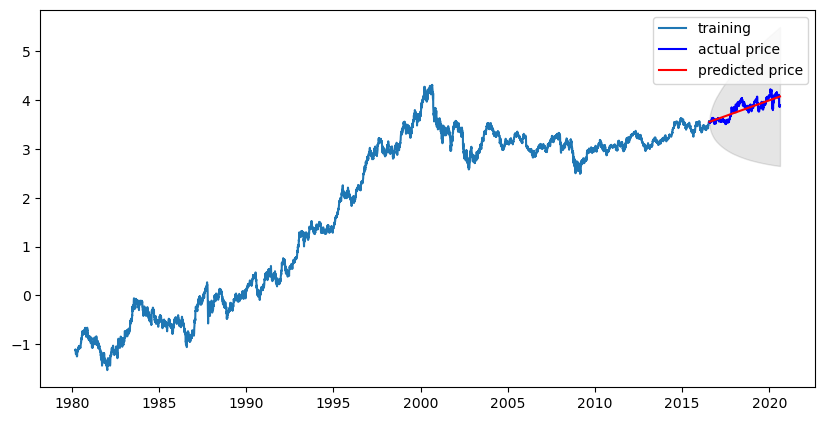

MSE:  20.856546050637082   
MAE:  3.550523830410475  
RMSE:  4.5668967637376126  
MAPE: 7.42%  

### LG 생건의 경우

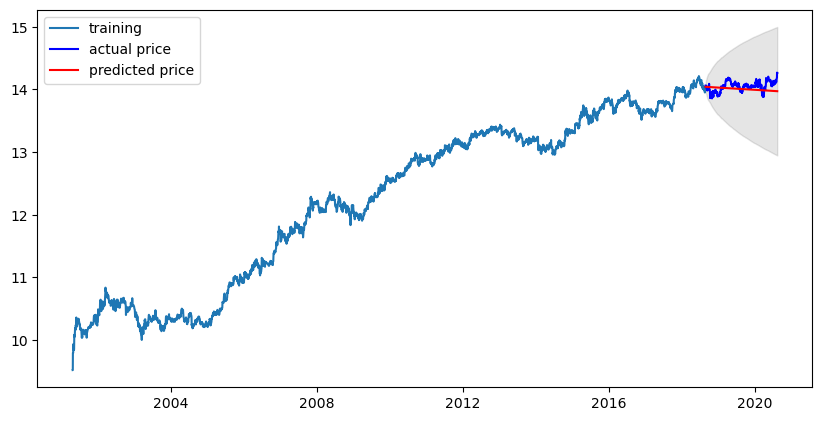

MSE:  15946288437.32268  
MAE:  105435.60995685209  
RMSE:  126278.61433086237  
MAPE: 8.15%  

### 한국조선해양의 경우

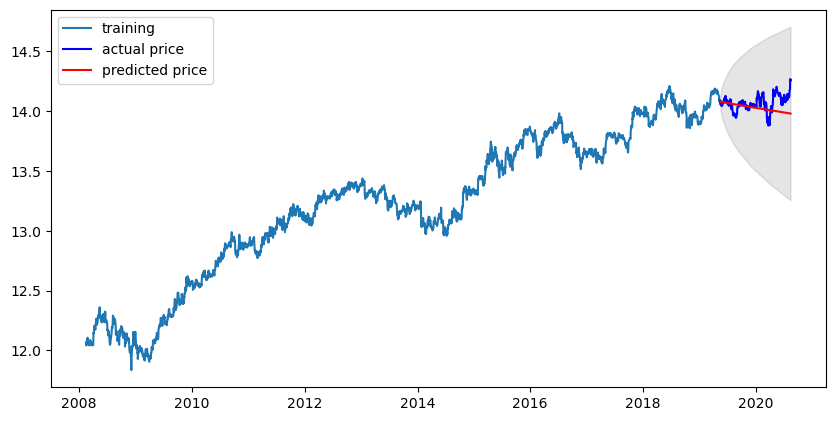

MSE:  12834275277.054686  
MAE:  83654.11367862315  
RMSE:  113288.46047614331  
MAPE: 6.31%  